## Comparing signature quality with signature similarity
### For PROGENy benchmark

In [1]:
#benchmark_progeny.py

In [63]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pckl
%matplotlib inline
sns.set_style("whitegrid")

import os

In [6]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/progeny/rocaucs/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/datasets//progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

Text(0, 0.5, 'Pathway size\n(# of experiments per PW)')

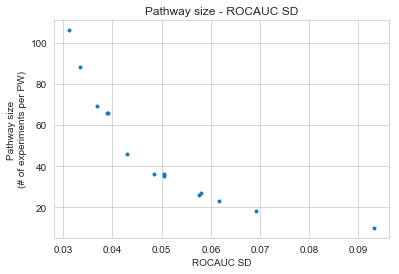

In [7]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Pathway size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Pathway size\n(# of experiments per PW)')

In [8]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/progeny/rocaucs/')
fnames.remove('random_dist.csv')
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/progeny/rocaucs/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/progeny/z_scores/%s.csv' % method, sep=',')

In [113]:
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

def compare_similarity_and_quality(tfname,pwname,method):
    tf_activity=pd.read_csv('../results/benchmark/progeny/z_scores///%s.csv' % tfname, 
                            sep=',',header=0,index_col=0).abs().max()
    pw_activity=pd.read_csv('../results/benchmark/progeny/z_scores////%s.csv' % pwname, 
                            sep=',',header=0,index_col=0).abs().max()
    fin=open('../results/genesets/single/dicts/%s.pkl' % tfname,'br')
    tfs=pckl.load(fin)
    fin.close()
    fin=open('../results/genesets/single/dicts/%s.pkl' % pwname,'br')
    pws=pckl.load(fin)
    fin.close()
    good_tfs=[]
    for tf in tfs:
        if (len(tfs[tf])<10000) & (len(tfs[tf])>-10):
            good_tfs.append(tf)
    good_tfs=list(set(good_tfs)&set(tf_activity.index))
    tf_activity=tf_activity[good_tfs]
    good_pws=[]
    for pw in pws:
        if (len(pws[pw])<10000) & (len(pws[pw])>-10):
            good_pws.append(pw)
    good_pws.append(pw)
    good_pws=list(set(good_pws)&set(pw_activity.index))
    pw_activity=pw_activity[good_pws]
    try:
        tf_pw_sim=pd.read_csv('../results/similarity//%s_%s_%s.csv' % (tfname,pwname,method),sep=',',
                             header=0,index_col=0)
        tf_pw_sim=tf_pw_sim.loc[good_tfs,good_pws]
    except:
        tf_pw_sim=pd.read_csv('../results/similarity//%s_%s_%s.csv' % (pwname,tfname,method),sep=',',
                             header=0,index_col=0).T
        tf_pw_sim=tf_pw_sim.loc[good_tfs,good_pws]
    tf_sim=np.max(tf_pw_sim,1)[tf_activity.index]
    pw_sim=np.max(tf_pw_sim,0)[pw_activity.index]
    f,axs=plt.subplots(1,2,figsize=(4,2),dpi=300)
    sns.regplot(tf_activity,tf_sim,ax=axs[0],scatter_kws={'s':2})
    sns.regplot(pw_activity,pw_sim,ax=axs[1],scatter_kws={'s':2})
    #axs[0].set_ylabel(method + ' with\n' + pw,size=7)
    #axs[1].set_ylabel(method + ' with\n' + tf,size=7)
    #axs[0].set_xlabel('Gene set quality\n(z score)',size=7)
    #axs[1].set_xlabel('Gene set quality\n(z score)',size=7)
    #axs[0].set_xticks([5,10])
    #axs[0].set_xticklabels([5,10],fontsize=5)
    #t=np.max(tf_sim)
    #axs[0].set_yticks([t/2,t])
    #axs[0].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    #axs[1].set_xticks([5,10])
    #axs[1].set_xticklabels([5,10],fontsize=5)
    #t=np.max(pw_sim)
    #axs[1].set_yticks([t/2,t])
    #axs[1].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    #plt.tight_layout()
    print(tf,scor(tf_activity,tf_sim),pcor(tf_activity,tf_sim))
    print(pw,scor(pw_activity,pw_sim),pcor(pw_activity,pw_sim))

SHEDDEN_LUNG_CANCER_POOR_SURVIVAL_A6 SpearmanrResult(correlation=0.18886884975800264, pvalue=7.761877913165642e-28) (0.1869642860156033, 2.6599610625331733e-27)
REACTOME_ASPARAGINE_N_LINKED_GLYCOSYLATION SpearmanrResult(correlation=0.3987810508611522, pvalue=1.966356600603092e-26) (0.38218645286822395, 3.0450134428318403e-24)


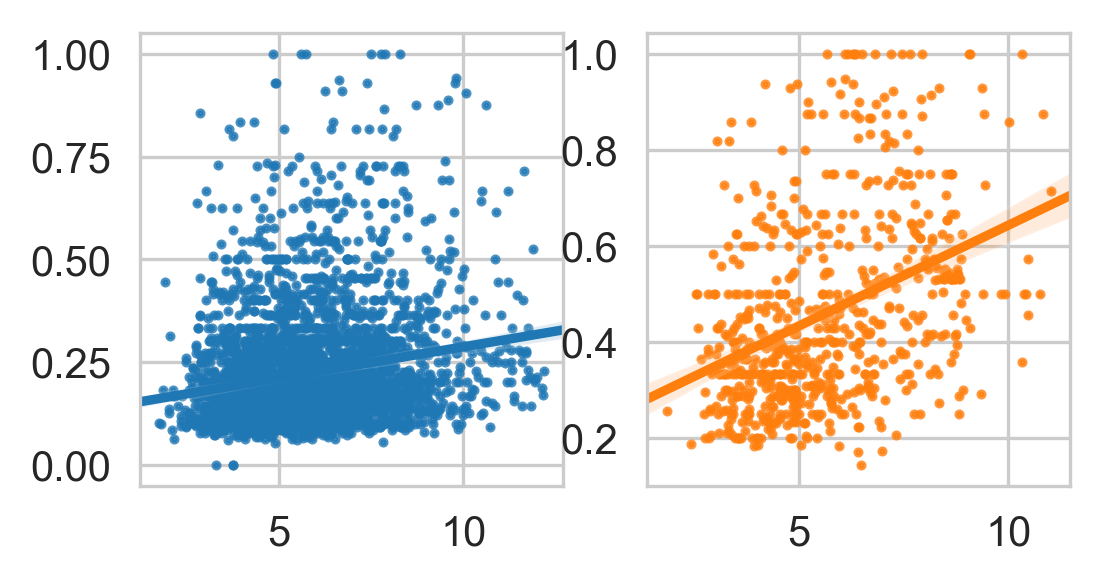

In [116]:
compare_similarity_and_quality('CGP','REACTOME','overlap')

In [50]:
def calc_matrix(tf,pw,method):
    tf_activity=pd.read_csv('../results/benchmark/progeny/z_scores///%s.csv' % tf, sep=',',header=0,index_col=0).abs().max()
    pw_activity=pd.read_csv('../results/benchmark/progeny/z_scores////%s.csv' % pw, sep=',',header=0,index_col=0).abs().max()
    try:
        tf_pw_sim=pd.read_csv('../results/similarity//%s_%s_%s.csv' % (tf,pw,method),sep=',',
                             header=0,index_col=0)
    except:
        tf_pw_sim=pd.read_csv('../results/similarity//%s_%s_%s.csv' % (pw,tf,method),sep=',',
                             header=0,index_col=0).T
    tf_sim=np.max(tf_pw_sim,1)[tf_activity.index]
    pw_sim=np.max(tf_pw_sim,0)[pw_activity.index]
    return scor(tf_activity,tf_sim)[0]

In [57]:
temp=pd.DataFrame(index=['dorothea_AB','CGP','KEGG','BIOCARTA','REACTOME'],
                  columns=['dorothea_AB','CGP','KEGG','BIOCARTA','REACTOME'])
for i in temp.index:
    for c in temp.columns:
        if i==c:
            temp.loc[i,c]=0
        else:
            temp.loc[i,c]=calc_matrix(i,c,'jaccard')

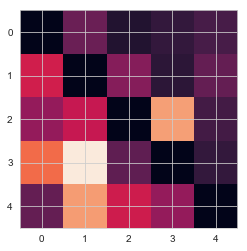

In [58]:
plt.imshow(temp.abs().astype(float))

In [59]:
temp['donor']=temp.index
temp=temp.melt('donor',temp.columns[:-1])


In [60]:
temp=temp[temp['value']!=0]
temp.index=range(len(temp))
temp['value']=temp['value'].astype(float)

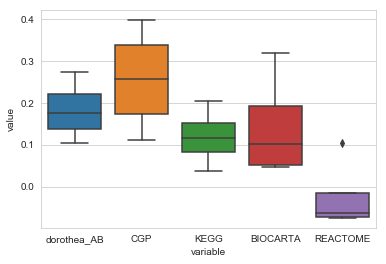

In [62]:
sns.boxplot(x='variable',y='value',data=temp)

In [29]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/tcga/rocaucs/random_dist.csv',sep=',',header=0,index_col=0)
tcga=pd.read_csv('../results/benchmark/datasets//tcga_meta.csv',
                        sep=',',header=0,index_col=0)
tcga=tcga['TCGA'].value_counts()
tcga=tcga[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=tcga

Text(0, 0.5, 'Pathway size\n(# of experiments per PW)')

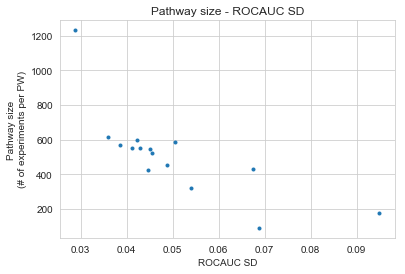

In [30]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Pathway size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Pathway size\n(# of experiments per PW)')

In [31]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/tcga/rocaucs/')
fnames.remove('random_dist.csv')
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/tcga/rocaucs/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/tcga/z_scores/%s.csv' % method, sep=',')

In [35]:
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

def compare_similarity_and_quality(tf,pw,method):
    tf_activity=pd.read_csv('../results/benchmark/tcga/z_scores//%s.csv' % tf, sep=',',header=0,index_col=0).abs().max()
    pw_activity=pd.read_csv('../results/benchmark/tcga/z_scores//%s.csv' % pw, sep=',',header=0,index_col=0).abs().max()
    try:
        tf_pw_sim=pd.read_csv('../results/similarity//%s_%s_%s.csv' % (tf,pw,method),sep=',',
                             header=0,index_col=0)
    except:
        tf_pw_sim=pd.read_csv('../results/similarity//%s_%s_%s.csv' % (pw,tf,method),sep=',',
                             header=0,index_col=0).T
    tf_sim=np.max(tf_pw_sim,1)[tf_activity.index]
    pw_sim=np.max(tf_pw_sim,0)[pw_activity.index]
    f,axs=plt.subplots(1,2,figsize=(4,2),dpi=300)
    sns.regplot(tf_activity,tf_sim,ax=axs[0],scatter_kws={'s':2})
    sns.regplot(pw_activity,pw_sim,ax=axs[1],scatter_kws={'s':2})
    #tf_sim=np.max(tf_pw_sim,1)[tf_activity.index]
    #pw_sim=np.max(tf_pw_sim,0)[pw_activity.index]
    #f,axs=plt.subplots(1,2,figsize=(4,2),dpi=300)
    #sns.regplot(tf_activity,tf_sim,ax=axs[0],scatter_kws={'s':2})
    #sns.regplot(pw_activity,pw_sim,ax=axs[1],scatter_kws={'s':2})
    #axs[0].set_ylabel(method + ' with\n' + pw,size=7)
    #axs[1].set_ylabel(method + ' with\n' + tf,size=7)
    #axs[0].set_xlabel('Gene set quality\n(z score)',size=7)
    #axs[1].set_xlabel('Gene set quality\n(z score)',size=7)
    #axs[0].set_xticks([5,10])
    #axs[0].set_xticklabels([5,10],fontsize=5)
    #t=np.max(tf_sim)
    #axs[0].set_yticks([t/2,t])
    #axs[0].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    #axs[1].set_xticks([5,10])
    #axs[1].set_xticklabels([5,10],fontsize=5)
    #t=np.max(pw_sim)
    #axs[1].set_yticks([t/2,t])
    #axs[1].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    plt.tight_layout()
    print(tf,scor(tf_activity,tf_sim),pcor(tf_activity,tf_sim))
    print(pw,scor(pw_activity,pw_sim),pcor(pw_activity,pw_sim))   

REACTOME SpearmanrResult(correlation=0.06905860079909382, pvalue=0.0736137014384969) (0.08828764717604874, 0.02208588541049324)
dorothea_AB SpearmanrResult(correlation=0.10631227219237419, pvalue=0.15902270748407255) (0.07611507206746644, 0.3139674821239686)


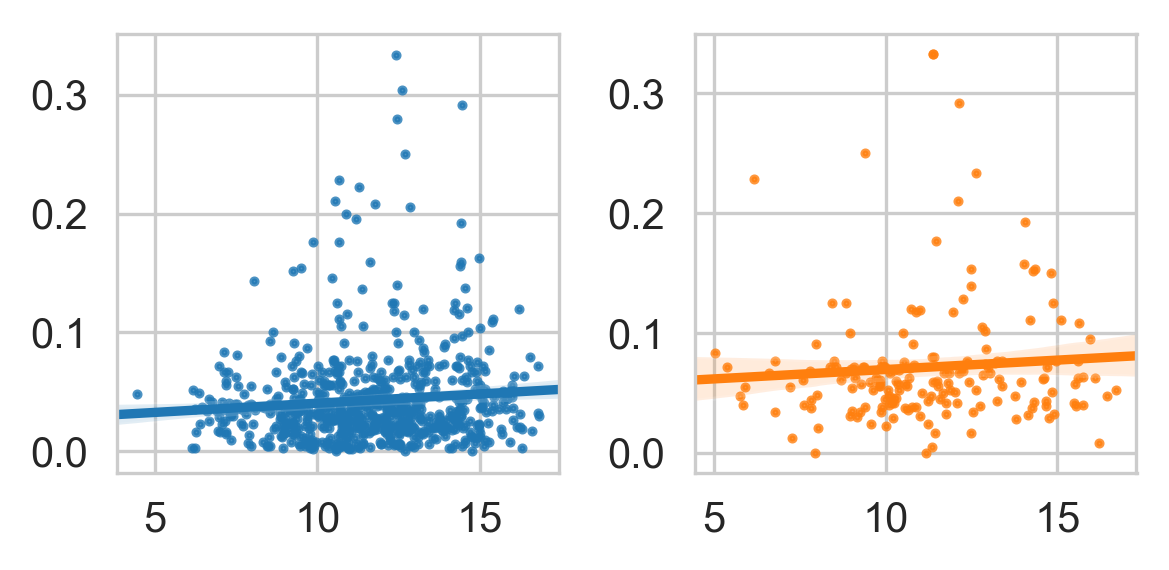

In [49]:
compare_similarity_and_quality('REACTOME','dorothea_AB','jaccard')

In [16]:
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

def compare_similarity_and_quality(tf,pw,method):
    tf_activity=pd.read_csv('../results/benchmark/gdsc/partcors//%s.csv' % tf, sep=',',header=0,index_col=0)
    tf_activity=((tf_activity.T-np.mean(tf_activity,1))/np.std(tf_activity,1)).T.abs().max()
    pw_activity=pd.read_csv('../results/benchmark/gdsc/partcors//%s.csv' % pw, sep=',',header=0,index_col=0)
    pw_activity=((pw_activity.T-np.mean(pw_activity,1))/np.std(pw_activity,1)).T.abs().max()
    tf_pw_sim=pd.read_csv('../results/similarity/similarity/%s_%s_%s.csv' % (tf,pw,method),sep=',',
                         header=0,index_col=0)
    tf_sim=np.max(tf_pw_sim,1)[tf_activity.index]
    pw_sim=np.max(tf_pw_sim,0)[pw_activity.index]
    f,axs=plt.subplots(1,2,figsize=(4,2),dpi=300)
    sns.regplot(tf_activity,tf_sim,ax=axs[0],scatter_kws={'s':2})
    sns.regplot(pw_activity,pw_sim,ax=axs[1],scatter_kws={'s':2})
    #axs[0].set_ylabel(method + ' with\n' + pw,size=7)
    #axs[1].set_ylabel(method + ' with\n' + tf,size=7)
    #axs[0].set_xlabel('Gene set quality\n(z score)',size=7)
    #axs[1].set_xlabel('Gene set quality\n(z score)',size=7)
    #axs[0].set_xticks([5,10])
    #axs[0].set_xticklabels([5,10],fontsize=5)
    #t=np.max(tf_sim)
    #axs[0].set_yticks([t/2,t])
    #axs[0].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    #axs[1].set_xticks([5,10])
    #axs[1].set_xticklabels([5,10],fontsize=5)
    #t=np.max(pw_sim)
    #axs[1].set_yticks([t/2,t])
    #axs[1].set_yticklabels([str(t/2)[:4],str(t)[:4]],fontsize=5)
    plt.tight_layout()
    print(tf,scor(tf_activity,tf_sim),pcor(tf_activity,tf_sim))
    print(pw,scor(pw_activity,pw_sim),pcor(pw_activity,pw_sim))   

dorothea_AB SpearmanrResult(correlation=-0.0064203755577212805, pvalue=0.9324098887038241) (-0.07798947118433458, 0.3021642176846287)
KEGG SpearmanrResult(correlation=-0.36677274367781004, pvalue=2.619231025252353e-07) (-0.3248556522555086, 6.071655782613547e-06)


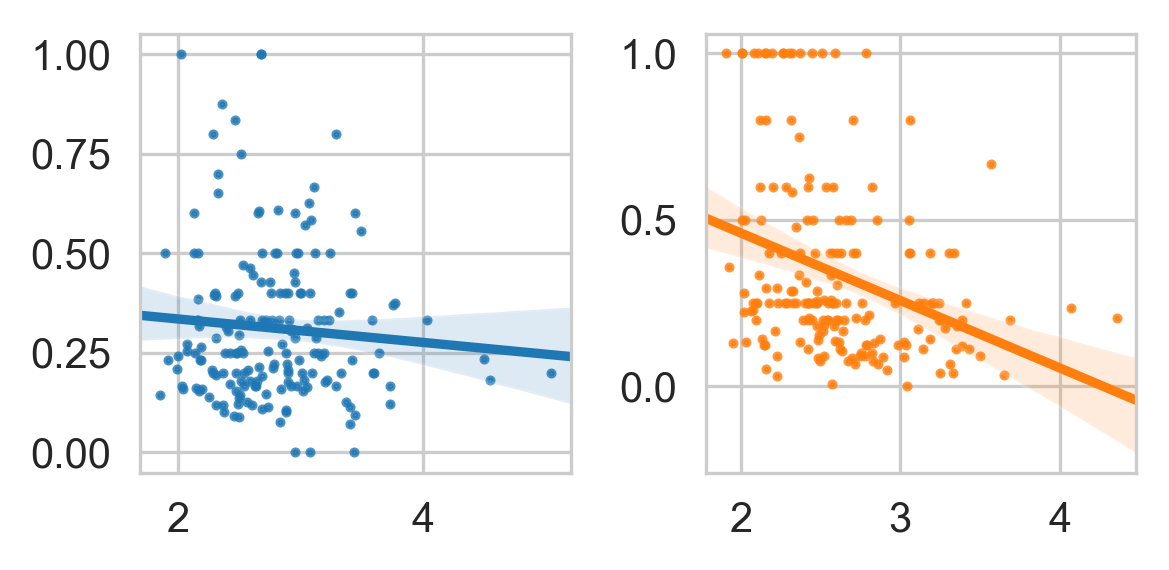

In [18]:
compare_similarity_and_quality('dorothea_AB','KEGG','overlap')

### Ovelap analysis

In [438]:
setname1='dorothea_AB'
setname2='KEGG'
zscore_th=6

In [439]:
scores1=pd.read_csv('../results/benchmark/progeny/z_scores/%s.csv' % setname1,sep=',',header=0,index_col=None)
scores2=pd.read_csv('../results/benchmark/progeny/z_scores/%s.csv' % setname2,sep=',',header=0,index_col=None)
scores1and2=pd.read_csv('../results/benchmark/progeny/z_scores/%s_overlap_%s.csv' % (setname1,setname2),
                       header=0,index_col=None)
scores1minus2=pd.read_csv('../results/benchmark/progeny/z_scores/%s_minus_%s.csv' % (setname1,setname2),
                       header=0,index_col=None)
scores2minus1=pd.read_csv('../results/benchmark/progeny/z_scores/%s_minus_%s.csv' % (setname2,setname1),
                       header=0,index_col=None)

In [440]:
scores1=scores1.melt(id_vars=scores1.columns[0],value_vars=scores1.columns[1:])
scores2=scores2.melt(id_vars=scores2.columns[0],value_vars=scores2.columns[1:])
scores1and2=scores1and2.melt(id_vars=scores1and2.columns[0],value_vars=scores1and2.columns[1:])
scores1minus2=scores1minus2.melt(id_vars=scores1minus2.columns[0],value_vars=scores1minus2.columns[1:])
scores2minus1=scores2minus1.melt(id_vars=scores2minus1.columns[0],value_vars=scores2minus1.columns[1:])

In [441]:
for temp in [scores1,scores2,scores1and2,scores1minus2,scores2minus1]:
    temp.columns=['pathway','geneset','zscore']
    temp['zscore']=temp['zscore'].abs()

In [442]:
scores1=scores1[scores1['zscore']>zscore_th]
scores2=scores2[scores2['zscore']>zscore_th]


In [443]:
for temp in [scores1and2,scores1minus2,scores2minus1]:
    temp['geneset1*PW']=temp['pathway']+'*'+temp['geneset'].apply(lambda x:x.split('*')[0])
    temp['geneset2*PW']=temp['pathway']+'*'+temp['geneset'].apply(lambda x:x.split('*')[1])

In [444]:
for temp in [scores1,scores2]:
    temp['geneset*PW']=temp['pathway']+'*'+temp['geneset']

In [445]:
fil=np.in1d(scores1and2['geneset1*PW'],scores1['geneset*PW']) & \
        np.in1d(scores1and2['geneset2*PW'],scores2['geneset*PW'])
scores1and2=scores1and2[fil]

fil=np.in1d(scores1minus2['geneset1*PW'],scores1['geneset*PW']) & \
        np.in1d(scores1minus2['geneset2*PW'],scores2['geneset*PW'])
scores1minus2=scores1minus2[fil]  

fil=np.in1d(scores2minus1['geneset1*PW'],scores1['geneset*PW']) & \
        np.in1d(scores2minus1['geneset2*PW'],scores2['geneset*PW'])
scores2minus1=scores2minus1[fil]  

In [446]:
names=['a','b','a&b','a-b','b-a']
for i in range(5):
    temp=[scores1,scores2,scores1and2,scores1minus2,scores2minus1][i]
    temp['name']=names[i]

In [447]:
results=pd.concat([scores1,scores2,scores1and2,scores1minus2,scores2minus1])

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


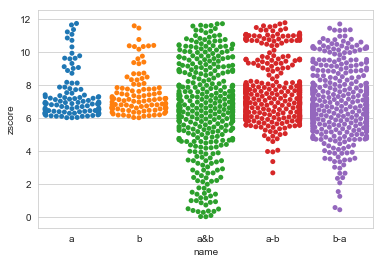

In [448]:
sns.swarmplot(y='zscore',x='name',data=results)

In [436]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu as mwu
mwu(scores1minus2['zscore'],scores2minus1['zscore'])

MannwhitneyuResult(statistic=1670.0, pvalue=5.00357502183309e-05)

In [385]:
len(scores2minus1)

453

In [358]:
for temp in [scores1,scores2,scores1and2,scores1minus2,scores2minus1]:
    print(np.mean(temp['zscore']),np.std(temp['zscore']))

7.393243920424232 1.4277092449914075
7.450571094902891 1.1062118971117438
6.275797414331159 2.798483492646094
7.422329713981523 1.562446478757376
7.062661252080064 1.4548126663172398


In [359]:
import pickle as pckl
fin=open('../results/genesets/overlaps/dicts/dorothea_AB_minus_REACTOME.pkl','rb')
geneset=pckl.load(fin)
scores1minus2['len']=0
for i in scores1minus2.index:
    scores1minus2.loc[i,'len']=len(geneset[scores1minus2.loc[i,'geneset']])

In [360]:
fin=open('../results/genesets/overlaps/dicts/REACTOME_minus_dorothea_AB.pkl','rb')
geneset=pckl.load(fin)
scores2minus1['len']=0
for i in scores2minus1.index:
    scores2minus1.loc[i,'len']=len(geneset[scores2minus1.loc[i,'geneset']])

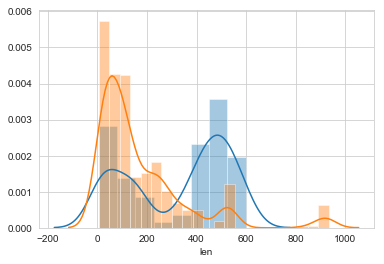

In [361]:
sns.distplot(scores1minus2['len'])
sns.distplot(scores2minus1['len'])

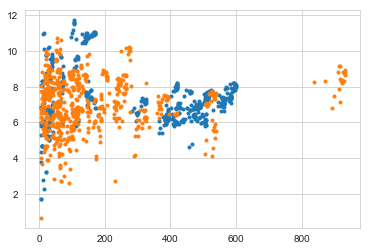

In [362]:
plt.plot(scores1minus2['len'],scores1minus2['zscore'],'.')
plt.plot(scores2minus1['len'],scores2minus1['zscore'],'.')

In [250]:
print(np.mean(scores1minus2['zscore']))
print(np.mean(scores2minus1['zscore']))
fil=scores1minus2['len']<300
print(np.mean(scores1minus2[fil]['zscore']))

7.588050668428567
6.866642547621664
8.305575387717248
